In [54]:
import os
os.getcwd()

'/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test'

In [55]:
# change dir to import from aesmc
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc")
import aesmc.statistics as statistics
import aesmc.inference as inference
import aesmc.train as train
import aesmc.losses as losses
import aesmc.state as state

In [56]:
# change dir to import from aesmc/test
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test")
from arm_models import LGSSM_general # the model script -- distribution objects are defined there
from arm_models import utils_summary

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [58]:
# matplotlib general settings 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

mpl.rcParams['lines.linewidth'] = 4.0

plot_folder = 'LGSSM_general_plots'

In [59]:
np.random.seed(0)
torch.manual_seed(0)

In [60]:
def plot_evals(matrix, g):
    w,v = np.linalg.eig(matrix)
    plt.vlines(x=0, ymin = -2, ymax=2)
    plt.hlines(y=0, xmin = -3, xmax = 2)
    plt.scatter(np.real(w), np.imag(w), zorder=3)
    plt.xlim(-3,2)
    plt.ylim(-2,2)
    plt.xlabel('$Re(\lambda)$')
    plt.ylabel('$Im(\lambda)$')
    plt.title('e-val spectrum, g = %.1f' %g);

Make sure you define A in a way that doesn't blow up.

In [65]:
# model specs
g = 0.2 # if defining a random matrix
dim_latents = 3
dim_obs = 1
initial_var_diag = 2.0
transition_var_diag = 0.2
emission_var_diag = 0.4
param_dict = {}
param_dict["init_mu"] = np.zeros(dim_latents)
param_dict["init_cov"] = np.eye(dim_latents) * initial_var_diag
# param_dict["A"] = np.random.normal(scale = 0.7/np.sqrt(dim_latents),
#                                    size = (dim_latents, dim_latents))
param_dict["A"] = np.random.normal(size = (dim_latents,dim_latents)) * \
        (g / np.sqrt(dim_latents)) #np.array([[0.6, -0.8], [0.7, 0.6]]) # previous plots used this. from boyd.
param_dict["Q"] = np.eye(dim_latents) * transition_var_diag
param_dict["C"] = np.random.normal(size = (dim_obs,dim_latents)) #np.zeros((dim_obs,dim_latents)) # 
#param_dict["C"][0,0] = 1.0
param_dict["R"] =  np.eye(dim_obs) * emission_var_diag

In the cell below we re-define some of the matrices to describe a moving particle.

In [66]:
# For the moving particle example
dt = 0.03
m = 1.25
transition_force_scale = 10 # WAS 2.0
transition_aux_scale = ((dt**2)*transition_force_scale**2) / 10.0
print('force effective variance: %.5f' %((dt**2)*transition_force_scale**2))
print('auxilliary variance: %.5f' % transition_aux_scale)

A = np.array([[0.0, 0.0, 0.0],[0.0,0.0,1.0],[1.0/m, 0.0, 0.0]])
param_dict["A"] = np.eye(3) + dt* A
param_dict["Q"] = np.diag([(dt**2)*transition_force_scale**2,
                         transition_aux_scale**2,
                        transition_aux_scale**2])
# actual readout
param_dict["C"] = np.zeros((dim_obs,dim_latents)) # np.random.normal(size = (dim_obs,dim_latents))
param_dict["C"][0,1] = 1.0
#param_dict["C"] = 3*np.random.normal(size = (dim_obs,dim_latents))
# hand code C 
#param_dict["C"] = np.array([[0.1, 1.0, 10.0]])

force effective variance: 0.09000
auxilliary variance: 0.00900


In [67]:
param_dict["C"]

array([[0., 1., 0.]])

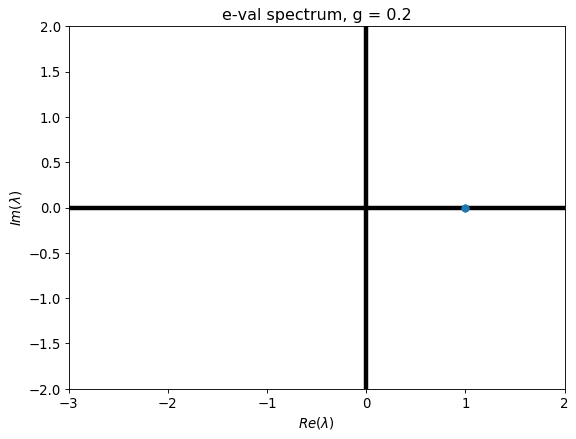

In [68]:
plot_evals(param_dict["A"], g)

In [69]:
# # if want a random stable matrix 
# import scipy as scipy
# AA = np.random.normal(scale = 2, size = (2,2))
# u_mat = scipy.linalg.orth(AA)
# A = np.zeros((2,2))
# evals = np.array([+0.2, -0.3])
# for i in range(2):
#     A= np.add(A, evals[i]*np.outer(u_mat[:,i],u_mat[:,i]), casting = "unsafe")
# param_dict["A"] = A

# print(u_mat)
# print(A)
# print(np.linalg.eig(A))

In [70]:
# running specs
num_timesteps = 200
num_particles = 1000
batch_size = 10 # NOTE - if manual data set, press 1
# following params are relevant if training:
saving_interval = 10
logging_interval = 10
num_iterations = 500

In [71]:
# initialize distribution objects
initial = LGSSM_general.Initial(param_dict["init_mu"], 
                                param_dict["init_cov"])
transition = LGSSM_general.Transition(param_dict["A"], 
                               param_dict["Q"])
emission = LGSSM_general.Emission(param_dict["C"],
                                  param_dict["R"])

In [72]:
# define proposal here
proposal = LGSSM_general.Bootstrap_Proposal(
                init_loc = param_dict["init_mu"], 
                init_cov_mat = param_dict["init_cov"], 
                A = param_dict["A"], 
                Q =  param_dict["Q"])

In [73]:
np.random.seed(0)
torch.manual_seed(0)

In [74]:
# simulate from the model
sim_lats , sim_observs = statistics.sample_from_prior(initial,
                                transition,
                                emission, 
                                num_timesteps,
                                batch_size)
print(sim_lats[-1].size()) # [batch_size, dim_latents]
print(sim_observs[-1].size()) # [batch_size, dim_obs]

torch.Size([10, 3])
torch.Size([10, 1])


In [75]:
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)
lat_data_np = lat_data.detach().numpy()
sim_data_np = sim_data.detach().numpy()

torch.Size([10, 3, 200])
torch.Size([10, 1, 200])


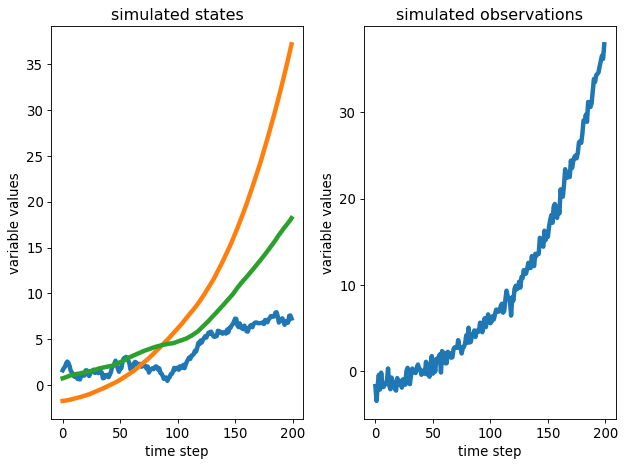

In [76]:
ind_in_batch = 4
plt.subplot(121)
plt.plot(lat_data_np[ind_in_batch, :, :].T);
plt.title('simulated states')
plt.ylabel('variable values')
plt.xlabel('time step')
plt.subplot(122)
plt.plot(sim_data_np[ind_in_batch, :, :].T);
plt.title('simulated observations')
plt.ylabel('variable values')
plt.xlabel('time step')
plt.tight_layout()
plt.savefig(plot_folder + '/particle_random_readout.png')

In [77]:
inference_result = inference.infer(
            inference_algorithm='smc',
            observations=sim_observs, 
            initial=initial,
            transition=transition,
            emission=emission,
            proposal=proposal,
            num_particles=num_particles,
            return_log_weights=True,
        )

In [360]:
def summarize_posterior(inference_result_list):
    '''compute empirical mean and variance using the final particle weights.'''
    
    # compute mean and variance of the latents
    smc_smoothed_state_means = []
    smc_smoothed_state_variances = []
    for latent in inference_result['latents']:
        smc_smoothed_state_means.append(statistics.empirical_mean(
            latent, inference_result['log_weight']
        ))
        smc_smoothed_state_variances.append(statistics.empirical_variance(
            latent, inference_result['log_weight']
        ))
    
    # compute effective sample size per timestep
    ESS = []
    for weight_set in inference_result["log_weights"]:
        ESS.append(statistics.ess(weight_set)) 

    # transform into a numpy array of shape batch_size X dim_latents X num_timesteps
    smooth_mean =  torch.cat([mean.unsqueeze(-1) for
                               mean in smc_smoothed_state_means], dim=2).detach().numpy()
    smooth_var = torch.cat([var.unsqueeze(-1) for
                               var in smc_smoothed_state_variances], dim=2).detach().numpy()
    ESS_cat =  torch.cat([ESS_i.unsqueeze(-1) for
                           ESS_i in ESS],
                         dim=1).detach().numpy()
    
    posterior_summary = {}
    posterior_summary["smooth_mean"] = smooth_mean
    posterior_summary["smooth_var"] = smooth_var
    posterior_summary["ESS"] = ESS_cat
    
    return posterior_summary

In [78]:
posterior_summary = utils_summary.summarize_posterior(inference_result)
#posterior_summary = summarize_posterior(inference_result)

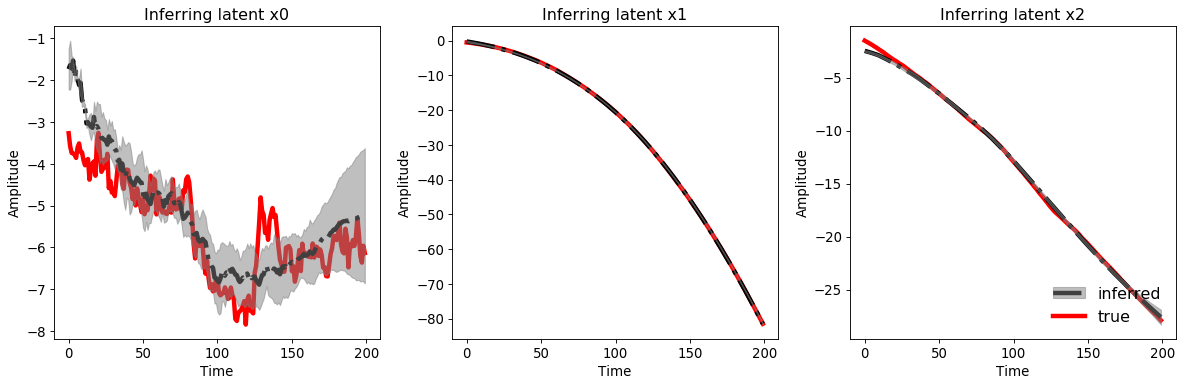

In [87]:
from arm_models import arm_utils
ind_in_batch = 0
nrows = 1
fig, axs = plt.subplots(nrows,int(posterior_summary["smooth_mean"].shape[1]/nrows), 
                        figsize = (15,5), sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(posterior_summary["smooth_mean"].shape[1]):
    
    title = 'x' + str(i)

    if i == (posterior_summary["smooth_mean"].shape[1]-1):
        plt_leg = True
        
    arm_utils.plot_posterior_trace(
                    post_mean = posterior_summary["smooth_mean"][ind_in_batch,i,:], 
                     post_var = np.sqrt(posterior_summary["smooth_var"][ind_in_batch,i,:]), 
                     data_vec = lat_data_np[ind_in_batch,i,:], 
                     alpha = 0.5, plot_legend=plt_leg, 
                     plot_uncertainty=True, plot_true_data=True, 
                     legends_list = ["inferred",
                                        "true"], 
                     legend_loc = "lower right", title = "Inferring latent " + title , 
                     xlabel = 'Time', ylabel = 'Amplitude', fig_fullname = None, 
                     ax = axs[i]);
fig.tight_layout()
plt.savefig(plot_folder+'/BPF_infer_latents_nosharey_4.png')

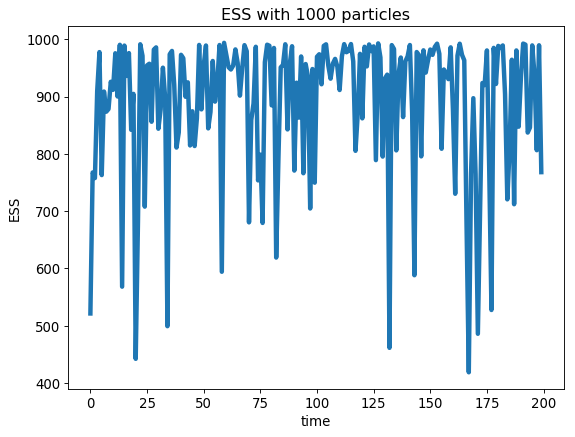

In [88]:
# plot ESS
plt.plot(posterior_summary["ESS"][ind_in_batch,:])
plt.xlabel('time')
plt.ylabel('ESS')
plt.title('ESS with %i particles' % num_particles);
plt.savefig(plot_folder+'/ESS_2_1.png')

In [89]:
# recover obs using the smooth mean
preds = np.zeros((dim_obs, num_timesteps))
preds_low = np.zeros((dim_obs, num_timesteps))
preds_high = np.zeros((dim_obs, num_timesteps))
for t in range(posterior_summary["smooth_mean"].shape[-1]):
    preds[:,t] = np.matmul(
                param_dict["C"],
                posterior_summary["smooth_mean"][ind_in_batch,:,t])
    preds_low[:,t] = np.matmul(
                param_dict["C"],
                posterior_summary["smooth_mean"][ind_in_batch,:,t]-
                np.sqrt(posterior_summary["smooth_var"][ind_in_batch,:,t]))
    preds_high[:,t] = np.matmul(
                param_dict["C"],
                posterior_summary["smooth_mean"][ind_in_batch,:,t]+
                np.sqrt(posterior_summary["smooth_var"][ind_in_batch,:,t]))

In [90]:
sim_data_np = sim_data.detach().numpy()

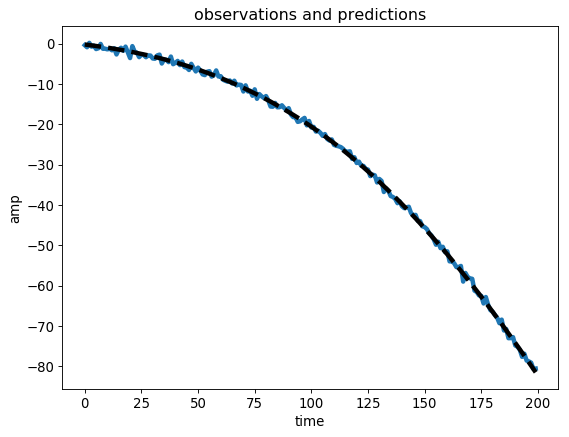

In [91]:
dim_obs_to_plot = 8
plt.plot(sim_data_np[ind_in_batch,:,:].T);
plt.plot(preds[:,:].T, 'k--');
# plt.fill_between(np.arange(sim_data_np.shape[-1]), 
#                  preds_low[dim_obs_to_plot,:],
#                 preds_high[dim_obs_to_plot,:], 
#                  color='gray', alpha=0.5, zorder=3)
plt.xlabel('time')
plt.ylabel('amp')
#plt.legend(['obs', 'predictions'])
plt.title('observations and predictions')
plt.savefig(plot_folder +'/pred_vs_obs.png')

In [92]:
measurements = sim_data_np[ind_in_batch,:,:].T
(measurements == sim_data_np[ind_in_batch,:,:].T).all()

True

In [93]:
# py kalman now. Do solns align?
from pykalman import KalmanFilter
import numpy as np
kf = KalmanFilter(initial_state_mean= param_dict["init_mu"],
                  initial_state_covariance= param_dict["init_cov"],
                transition_matrices = param_dict["A"], 
                  transition_covariance= param_dict["Q"],
                  observation_matrices = param_dict["C"],
                 observation_covariance= param_dict["R"])

In [94]:
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

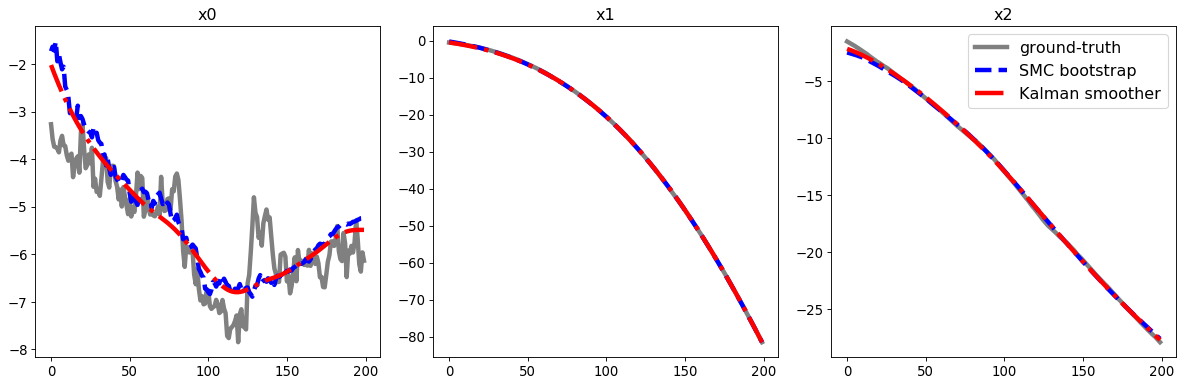

In [99]:
from arm_models import arm_utils
nrows = 1
fig, axs = plt.subplots(nrows,int(posterior_summary["smooth_mean"].shape[1]/nrows), 
                        figsize = (15,5), sharey=False)
titles = ['$x_{1}$', '$x_{2}$']
plt_leg = False
axs = axs.flatten()
for i in range(posterior_summary["smooth_mean"].shape[1]):
    
    title = 'x' + str(i)
    
    axs[i].plot(lat_data_np[ind_in_batch,i,:], color = 'gray', label = "ground-truth")
    axs[i].plot(posterior_summary["smooth_mean"][ind_in_batch,i,:], color = 'blue', linestyle = 'dashed',
                label = 'SMC bootstrap')
    axs[i].plot(smoothed_state_means[:,i], color = 'red', linestyle = 'dashdot', 
                label = 'Kalman smoother');
#     axs[i].plot(filtered_state_means[:,i], color = 'black', linestyle = 'dotted', 
#                 label = 'Kalman filter');
    axs[i].set_title(title)

axs[posterior_summary["smooth_mean"].shape[1]-1].legend()
fig.tight_layout()
plt.savefig(plot_folder+'/moving_particle_compare_diff_y.png')

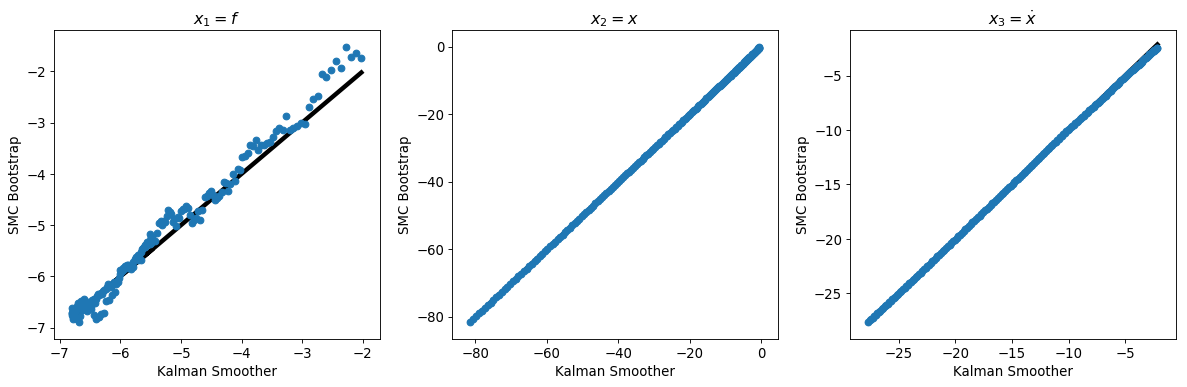

In [98]:
titles = ['$x_{1}$', '$x_{2}$']
plt_leg = False
nrows = 1
fig, axs = plt.subplots(nrows,int(posterior_summary["smooth_mean"].shape[1]/nrows), 
                        figsize = (15,5), sharey=False)
axs = axs.flatten()
for i in range(posterior_summary["smooth_mean"].shape[1]):
    
    if i == 0:
        label = '$x_{1} = f$'
    elif i == 1:
        label = '$x_{2} = x$'
    elif i == 2:
        label = '$x_{3} = \dot{x}$'
        plt_leg = True
    
    axs[i].plot(smoothed_state_means[:,i], smoothed_state_means[:,i], 'k') # diag line
    axs[i].scatter(smoothed_state_means[:,i], 
            posterior_summary["smooth_mean"][ind_in_batch,i,:], zorder=3)
    axs[i].set_xlabel('Kalman Smoother')
    axs[i].set_ylabel('SMC Bootstrap')
#     axs[i].plot(filtered_state_means[:,i], color = 'black', linestyle = 'dotted', 
#                 label = 'Kalman filter');
    axs[i].set_title(label)

#axs[1].legend()
fig.tight_layout()
plt.savefig(plot_folder+'/compare_ks_bpf_1_2_diff.png')